# ImageClassification-AI: Modelo T
### **Fine Tuning**

Modelo que faz uso da técnica de transfer learning, Fine Tuning. Este modelo faz uso do modelo VGG16.

### 1. Setup

#### 1.1 Importar dependências

Importação das bibliotecas necessárias para o desenvolvimento do modelo.
É de notar as bibliotecas:
* Tensorflow e Keras, que vão ser utilizadas na construção do modelo e no seu processo de treino

* Matplotlib (em específico o pyplot), Seaborn e sklearn, que vão ser utilizadas para facilitar a análise e a compreensão das métricas atribuidas ao modelo, da sua evolução, e dos resultados obtidos.

* Image_dataset_from_directory (através do keras.utils), numpy e os para o carregamento e tratamento dos dados.

* VGG16 que é o modelo que vai ser utilizado para construir e trainar o modelo

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers, regularizers, optimizers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16

#### 1.2 Desativar warnings do Tensorflow

Para desenvolvimento deste modelo foi utilizada a versão 2.10.0 do Tensorflow. Devido a este facto, ficou compreendido que seria de valor desativar algumas mensagens de warning dadas pelo Tensorflow, deixando o este apenas mostrar mensagens de erro, com o intuito de melhorar substancialmente a legibilidade do notebook. É importante realçar que, nenhuma das mensagens de aviso que serão desativadas em algum momento afetam qualquer aspeto do modelo ou sequer ajudam a compreender potenciais problemas com este.

In [2]:
tf.get_logger().setLevel('ERROR')

#### 1.3 Tratamento de dados

Definição das classes do problema, do tamanho das imagens RGB (224x224x3 pixeis), tamanho de cada batch (32) e as diretorias dos datasets de treino, validação e teste.

Para a criação dos datasets é utilizado o image_dataset_from_directory com os paramêtros relativos à diretoria onde estão as imagens, o tamanho destas, o tamanho de cada batch, a definição das labels como categorical (requerido devido ao facto do problema em questão envolver 10 classes; as labels serão um tensor float32 de tamanho (batch_size, num_classes), que iram representar, cada, um one-hot encoding de cada index de cada classe). Aqui é, ainda, importar notar que:

* O dataset de treino está a ser baralhado de modo a que, durante o processo de treino, o modelo não decore padrões nas imagens de treino. Para além disso, é relevante perceber que o dataset de treino é construido através da concatenação de quatro datasets de treino mais pequenos (cada um relativo a uma das diretoria de treino)

* Os datasets de validação e de testes não são baralhados. Ao baralhar o dataset de treino a análise dos resultados obtidos pelo modelo, neste, seria extremamente dificultada (e.g. ao construir um classification report para este dataset os resultados seriam incorretos porque as labels não iriam corresponder). No que toca ao dataset de validação, a questão entre baralhar ou não acaba por ser irrelevante já que não existe nenhum tipo de beneficio para o fazer. Isto foi confirmado por uma pesquisa sobre o assunto e por tentativas de treino do modelo com o dataset de validação baralhado e sem estar baralhado (os resultados eram os mesmo)

* As imagens foram resized do seu tamanho original de 32x32x3 para 224x224x3. Este valor foi escolhido pois é o valor por omissão utilizado pelo modelo VGG16.

In [3]:
class_names = []

IMG_SIZE = 224
BATCH_SIZE = 32

train_dirs = ['train1', 'train2', 'train3', 'train5']
val_dir = 'train4'
test_dir = 'test'

print("BUILDING TRAIN DATASET...")
train_dataset_list = []
for td in train_dirs:
    train_dataset_list.append(image_dataset_from_directory(td, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True, color_mode='rgb'))

train_dataset = train_dataset_list[0]
for name in train_dataset_list[0].class_names:
    idx = name.index('_') + 1
    class_names.append(name[idx:])

for d in train_dataset_list[1:]:
    train_dataset = train_dataset.concatenate(d)

print("\nBUILDING VALIDATION DATASET...")
val_dataset = image_dataset_from_directory(val_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False,color_mode='rgb')

print("\nBUILDING TEST DATASET...")
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False, color_mode='rgb')

BUILDING TRAIN DATASET...
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.

BUILDING VALIDATION DATASET...
Found 10000 files belonging to 10 classes.

BUILDING TEST DATASET...
Found 10000 files belonging to 10 classes.


### 2. Visualização

#### 2.1 - Classes e número de imagens

Visualização das classes que envolvem o problema e da quantidade de imagens contidas em cada dataset

In [4]:
print("\nClasses: " + str(class_names))

total_train = 0
for td in train_dirs:
    class_folders = next(os.walk(td))[1]
    for cf in class_folders:
        total_train += len(os.listdir(os.path.join(td, cf)))

total_val = 0
class_folders = next(os.walk(val_dir))[1]
for folder in class_folders:
    folder_path = os.path.join(val_dir, folder)
    total_val += len(os.listdir(folder_path))

total_test = 0
class_folders = next(os.walk(test_dir))[1]
for folder in class_folders:
    folder_path = os.path.join(test_dir, folder)
    total_test += len(os.listdir(folder_path))

print("Dataset de treino: " + str(total_train) + " imagens")
print("Dataset de validação: " + str(total_val) + " imagens")
print("Dataset de teste: " + str(total_test) + " imagens")


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset de treino: 40000 imagens
Dataset de validação: 10000 imagens
Dataset de teste: 10000 imagens


#### 2.2 Tamanhos

Visualização do tamanhos:
* Cada batch tem 32 imagens
* Cada imagem RGB tem 224x224 pixeis (224x224x3)
* Cada batch de labels tem 10 classes

In [5]:
for data_batch, label_batch in train_dataset:
    print('Shape de cada data batch: ', data_batch.shape)
    print('Shape de cada label batch: ', label_batch.shape)
    break

Shape de cada data batch:  (32, 224, 224, 3)
Shape de cada label batch:  (32, 10)


#### 2.3 - Normalização

Visualização da normalização dos pixeis:
* Divisão do valor de cada pixel por 255
* Operação definida, posteriormente, na construção do modelo e, feita durante o processo de treino para cada imagem de modo a que cada pixel tenha um valor associado que pertença ao intervalo de [0,1].
* Mostrar como o modelo irá "ver" cada imagem

In [6]:
iterator = train_dataset.as_numpy_iterator()
batch = iterator.next()
batch[0] / 255 # normalizar (feito no VGG16)

array([[[[0.3372549 , 0.24705882, 0.4627451 ],
         [0.3372549 , 0.24705882, 0.4627451 ],
         [0.3372549 , 0.24705882, 0.4627451 ],
         ...,
         [0.3882353 , 0.29803923, 0.49019608],
         [0.3882353 , 0.29803923, 0.49019608],
         [0.3882353 , 0.29803923, 0.49019608]],

        [[0.3372549 , 0.24705882, 0.4627451 ],
         [0.3372549 , 0.24705882, 0.4627451 ],
         [0.3372549 , 0.24705882, 0.4627451 ],
         ...,
         [0.3882353 , 0.29803923, 0.49019608],
         [0.3882353 , 0.29803923, 0.49019608],
         [0.3882353 , 0.29803923, 0.49019608]],

        [[0.3372549 , 0.24705882, 0.4627451 ],
         [0.3372549 , 0.24705882, 0.4627451 ],
         [0.3372549 , 0.24705882, 0.4627451 ],
         ...,
         [0.3882353 , 0.29803923, 0.49019608],
         [0.3882353 , 0.29803923, 0.49019608],
         [0.3882353 , 0.29803923, 0.49019608]],

        ...,

        [[0.44313726, 0.31764707, 0.5411765 ],
         [0.44313726, 0.31764707, 0.5411765 ]

#### 2.4 - Imagens do dataset de treino

Visualização de dez imagens aleatórias do dataset de treino.

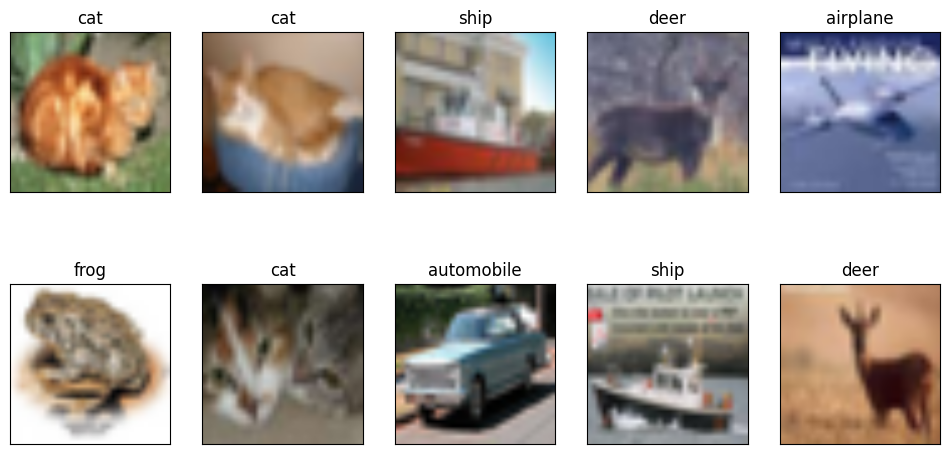

In [7]:
plt.figure(figsize=(12, 6))  # Aumentar o tamanho das imagens no plot

for data_batch, label_batch in train_dataset.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.imshow(data_batch[i].numpy().astype('uint8'))
        plt.xticks([])
        plt.yticks([])
    plt.show()

### 3. Modelo

#### 3.1 Carregamento do modelo T com Feature Extraction

É carregado o modelo T com feature extraction e sem data augmentation para uso futuro e avaliação imediata deste no dataset de teste.

In [8]:
# Carregar o modelo
model = keras.models.load_model('models/IC_T_FE.keras')

# Avaliar o modelo
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)

print("Test accuracy: ", test_acc)
print("Test loss: ", test_loss)
print("Test precision: ", test_precision)
print("Test recall: ", test_recall)

313/313 [==============================] - 33s 81ms/step - loss: 0.4230 - accuracy: 0.8854 - precision: 0.9083 - recall: 0.8635
Test accuracy:  0.8853999972343445
Test loss:  0.4229614734649658
Test precision:  0.9082781076431274
Test recall:  0.8634999990463257


#### 3.2 Carregar o modelo VGG16

Carregar o modelo VGG16 e congelar todas as camadas excepto, as últimas quatro.

In [9]:
conv_base = model.get_layer('vgg16')
conv_base.trainable = True

for layer in conv_base.layers[:-4]:
    layer.trainable = False

#### 3.3 Compilação

É utilizada a função de loss "categorical_crossentropy" devido à natureza do problema (várias classes).
Para analisar o desempenho do modelo são utilizadas metricas de acerto (neste caso o "CategorialAccuracy" em vez do Accuracy normal devido ao contexto do problema), precisão e recall. É, ainda, importante referir que inicialmente era para ser incluida uma métrica de calculo relativo ao F1-Score, mas, devido ao facto de ter sido utilizado o Tensorflow 2.10.0 para treinar os modelos, como supramencionado, não foi possível utilizar esta métrica. Isto acontece porque esta versão do Tensorflow não suporta a referida metrica. Realizaram-se experiências utilizando a métrica F1-Score do Tensorflow Addons mas, os resultados não foram satisfatórios.

Neste modelo T foi utilizado o optimizador SGD (Stochastic Gradient Descent) com os valores de learning rate = 0.0001 e momentum = 0.9. A escolha deste valores foi feita com base numa pesquisa que envolveu a procura de valores base para utilizar com este optimizador.

In [10]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
)

#### 3.4 Processo de treino

São definidas callbacks de:
* EarlyStopping, que vai servir para interromper o processo de treino. É monitorizada a loss no dataset de validação em cada epoch e, se após 10 epochs não houver melhoria desta métrica, então o treino vai ser interrompido

* ModelCheckpoint, que vai permitir guardar o melhor modelo obtido durante o processo de treino (em troca de se guardar o modelo na ultima epoch de treino que, pode não ser necessáriamente o melhor como é o caso de, por exemplo, situações onde o modelo começa a entrar em overfitting). Aqui é definida a diretoria onde guardar o melhor modelo e a metrica de monitorização que, neste caso, volta a ser a loss no dataset de validação. É, também utilizado o verbose para melhorar a compreensão do processo de treino.

Com isto, é, então, realizado o processo de treino (model.fit()) utilzando:

* O dataset de treino
* 20 epochs **(por problemas de hardware que acabaram por causar constrangimentos de tempo, foi necessário reduzir o número de epochs que estava inicialmente definido)**
* O dataset de validação para representar a capacidade de generalização do modelo
* As callbacks de EarlyStopping e ModelCheckpoint definidas

In [11]:
# Definir as callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5, 
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='models/IC_T_FT.keras',
        save_best_only = True,
        monitor='val_loss',
        verbose=1
)]

# Treinar o modelo
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/20
1252/1252 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9690 - precision: 0.9790 - recall: 0.9554
Epoch 1: val_loss improved from inf to 0.37991, saving model to models\IC_T_FT.keras
1252/1252 [==============================] - 137s 108ms/step - loss: 0.1951 - accuracy: 0.9690 - precision: 0.9790 - recall: 0.9554 - val_loss: 0.3799 - val_accuracy: 0.8989 - val_precision: 0.9243 - val_recall: 0.8784
Epoch 2/20
1252/1252 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9769 - precision: 0.9843 - recall: 0.9662
Epoch 2: val_loss improved from 0.37991 to 0.37185, saving model to models\IC_T_FT.keras
1252/1252 [==============================] - 136s 109ms/step - loss: 0.1705 - accuracy: 0.9769 - precision: 0.9843 - recall: 0.9662 - val_loss: 0.3718 - val_accuracy: 0.9021 - val_precision: 0.9269 - val_recall: 0.8841
Epoch 3/20
1252/1252 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9828 - precision: 0.9885 

#### 3.5 Avaliação

O melhor modelo obtido durante o processo de treino é carregado e avaliado utilizando o dataset de teste. Aqui é mostrado os valores das métricas de accuracy, loss, precision e recall obtidas pelo modelo nas imagens de teste.

In [12]:
# Carregar o melhor modelo obtido durante o processo de treino
model = keras.models.load_model('models/IC_T_FT.keras')

# Avaliar o modelo para o dataset de teste
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)

print("Test Accuracy: " + str(test_acc))
print("Test Loss: " + str(test_loss))
print("Test Precision: " + str(test_precision))
print("Test Recall: " + str(test_recall))

313/313 [==============================] - 25s 77ms/step - loss: 0.3332 - accuracy: 0.9122 - precision: 0.9321 - recall: 0.8926
Test Accuracy: 0.9121999740600586
Test Loss: 0.33316770195961
Test Precision: 0.932121992111206
Test Recall: 0.8925999999046326


### 4. Análise de resultados

#### 4.1 Evolução das métricas durante o processo de treino

É utilizado gráficos para melhor compreender de que maneira as métricas, nomeadamente a accuracy, loss, precision e recall, foram evoluindo ao longo do processo de treino.

É possível observar que:

* O constrangimento causado pelos problemas de hardware supramencionado afetou o desempenho final do modelo pois, é visível pela evolução das curvas que existe espaço para melhorar o modelo com mais épocas de treino.

* Existe um pequeno problema de overfitting que, é previsível, que se tornaria mais preponderante se o modelo fosse treinado durante mais épocas

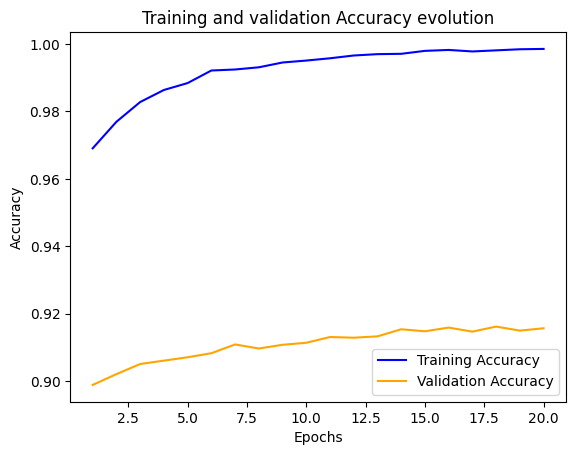

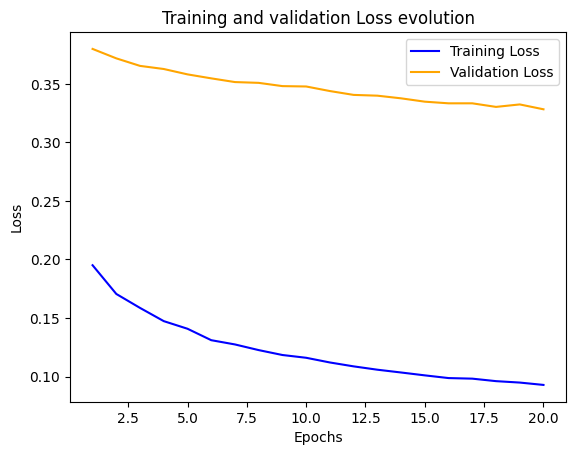

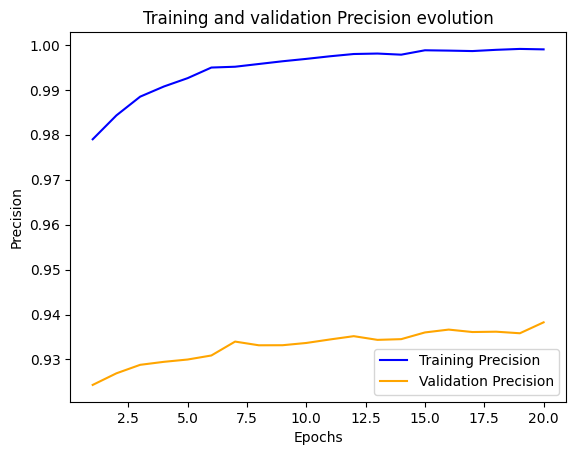

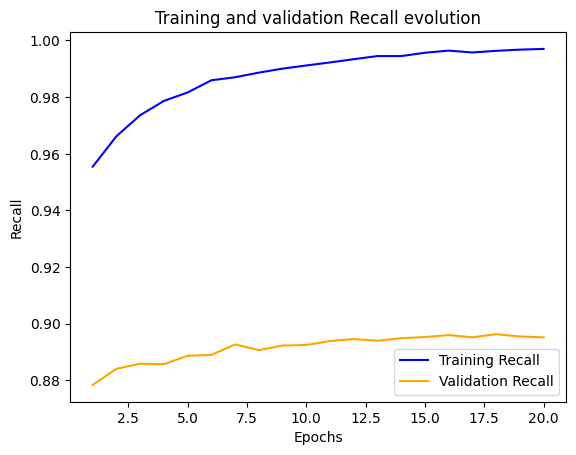

In [13]:
# Buscar as métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

# Calcular o número de épocas que foram realizadas
epochs = range(1, len(acc) + 1)

# Gráfico da accuracy
plt.plot(epochs, acc, 'blue', label='Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
plt.title('Training and validation Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

# Gráfico da loss
plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

# Gráfico da precision
plt.plot(epochs, precision, 'blue', label='Training Precision')
plt.plot(epochs, val_precision, 'orange', label='Validation Precision')
plt.title('Training and validation Precision evolution')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.figure()

# Gráfico do recall
plt.plot(epochs, recall, 'blue', label='Training Recall')
plt.plot(epochs, val_recall, 'orange', label='Validation Recall')
plt.title('Training and validation Recall evolution')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

#### 4.2 Desempenho no dataset de teste

De modo a compreender o real desempenho do modelo precisamos avaliar este utilizando o dataset de teste (que contém imagens que o este nunca viu anteriormente).

São feitas, e guardadas, previsões do modelo sobre o dataset de teste para, posteriormente, ser criado um classification report, que nos vai permitir analisar a taxa de acerto global e a precision, recall e f1-score para cada classe. Para além disso, é, também, construida uma matriz de confusão que, vai permitir ilustrar de uma outra maneira as previsões (vai ser possível ver, por exemplo, que quando a imagem pertencia à classe "dog", o modelo achou n vezes que a imagem pertencia à classe "cat").

Com isto, podemos compreender que:

* O modelo obtem resultados satisfatórios

* Existem várias classes com mais de 90% de previsões corretas. Estas são:
    
    * Airplane
    * Automobile
    * Deer
    * Frog
    * Horse
    * Ship
    * Truck

* As restantes classes, apesar de não conseguirem obter uma classificação acima de 90% de previsões corretas também, contém uma satisfatória percentagem de previsões corretas.

* É de notar que, a classe Cat é, para o modelo, a mais complicada de classificar, o que é facilmente percetivel pela observação das suas métricas de precision, recall e f1-score.
    

313/313 [==============================] - 23s 73ms/step
              precision    recall  f1-score   support

    airplane       0.93      0.95      0.94      1000
  automobile       0.95      0.96      0.95      1000
        bird       0.89      0.87      0.88      1000
         cat       0.80      0.84      0.82      1000
        deer       0.89      0.91      0.90      1000
         dog       0.88      0.84      0.86      1000
        frog       0.93      0.94      0.94      1000
       horse       0.94      0.92      0.93      1000
        ship       0.94      0.96      0.95      1000
       truck       0.96      0.94      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



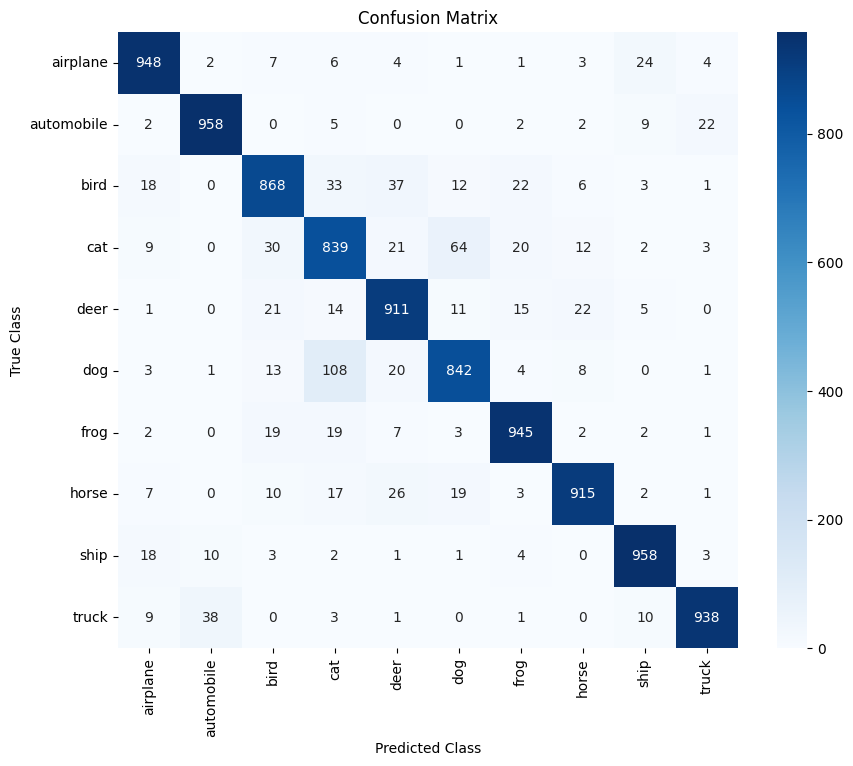

In [14]:
# Fazer previsões para o dataset de teste
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Obter as classes verdadeiras de cada imagem no dataset de teste
true_classes = []
for images, labels in test_dataset:
    true_classes.extend(np.argmax(labels.numpy(), axis=1))
true_classes = np.array(true_classes)

# Criar o classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)

# Mostrar a matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#### 4.3 Visualização de previsões

Aqui fazemos a visualização de imagens tal como anteriormente, mas introduzimos a previsão do modelo para cada uma das imagens, sendo possível visualizar, também, a classe real de cada imagem.

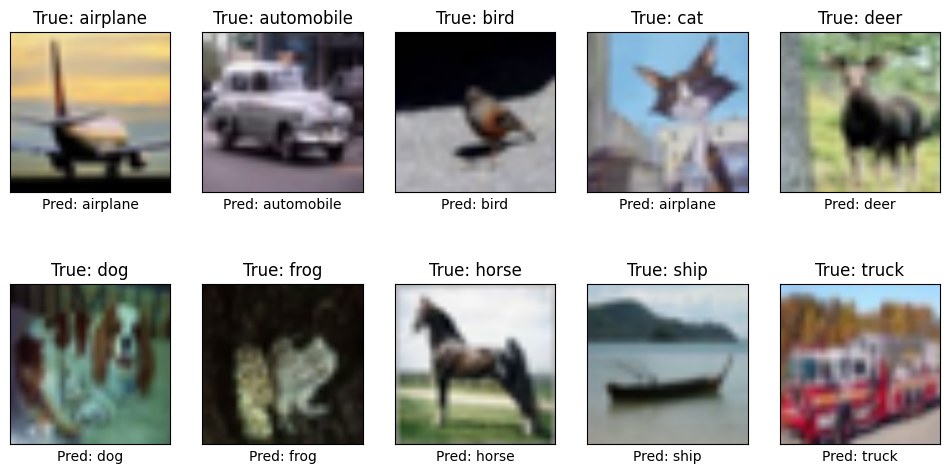

In [15]:
displayed_classes = set()

plt.figure(figsize=(12, 6))  # Ajustar o tamanho das imagens

for data_batch, label_batch in test_dataset:
    for i in range(len(label_batch)):
        true_class_idx = np.argmax(label_batch[i])
        true_label = class_names[true_class_idx]
        
        if true_class_idx not in displayed_classes:
            displayed_classes.add(true_class_idx)
            
            plt.subplot(2, 5, len(displayed_classes))
            
            pred_label = model.predict(np.expand_dims(data_batch[i], axis=0), verbose=0)
            pred_label = class_names[np.argmax(pred_label)]

            plt.title("True: " + true_label)
            plt.xlabel("Pred: " + pred_label)
            plt.imshow(data_batch[i].numpy().astype('uint8'))
            plt.xticks([])
            plt.yticks([])
        
        # Stop condition para no caso de já terem sido mostrada 10 imagens
        if len(displayed_classes) == 10:
            break
    if len(displayed_classes) == 10:
        break

plt.show()

### Conclusões

Tal como no modelo T treinado com Feature Extraction, este modelo sofre de overfitting que aparenta ser mais preponderante do que real é pelo intervalo de valores no eixo das ordernadas.

É perspectivavel que, com técnicas de Data Augmentation, o problema de overfitting irá ficar resolvido. Existem outras opções para resolver este problema como, por exemplo, técnicas de regularização que, poderam fazer parte de uma futura experiência que tenha o intuito de melhorar o modelo.

Com isto, é perspectivável que, se o notebook fosse executado com o número de épocas inicialmente definido, os resultados obtidos neste modelo fossem ligeiramente superiores, num intervalo de 1-2% de aumento nas métricas (tal como nos resultados de execuções anteriores).

Por fim, sentimos a importância de realçar, novamente, o problema de hardware que afetou o processo de treino deste modelo. Este modelo foi treinado várias vezes ao longo do processo de desenvolvimento do projeto. Antes de efetuarmos o treino final apágamos todas as células de outputs presentes de modo a facilitar a introdução de markdowns. Após iniciar o processo de correr o notebook pela última vez, ausentámo-nos da máquina em que este estava a ser executado devido ao facto der ser previsível que o processo fosse demorado. Ao regressarmos, apercebermo-nos que a máquina tinha crashado, mais em especifício, a GPU. Isto teve como consequência um processo de reparo da situação, que levou o seu tempo, e que não nos deixou com uma quantidade de tempo sucifiente para executar o notebook da maneira que este estava previamente definido.

### Bibliografia

https://www.markdownguide.org/basic-syntax/

https://www.tensorflow.org/

https://keras.io/api/applications/

https://keras.io/api/optimizers/

https://keras.io/api/data_loading/

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

https://nchlis.github.io/2017_08_10/page.html

https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7